In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [132]:
stockdt = pd.read_csv('./data/ibm_stock_prices_2000_2025.csv', header=[0,1], index_col=0, parse_dates=True)

In [133]:
stockdt

Price,Close,High,Low,Open,Volume
Ticker,IBM,IBM,IBM,IBM,IBM
Date,,,,,
2000-01-03,58.507248,58.507248,56.426713,56.710420,10823694
2000-01-04,56.521252,57.750660,55.922309,57.498474,8606279
2000-01-05,58.507248,60.398648,56.552807,56.962607,13318927
2000-01-06,57.498493,59.988832,57.246307,59.515983,8338607
2000-01-07,57.246300,59.484451,55.796228,59.137696,12402108
...,...,...,...,...,...
2025-04-24,229.330002,232.779999,224.440002,231.179993,15428100
2025-04-25,232.410004,233.360001,226.320007,228.949997,6700100


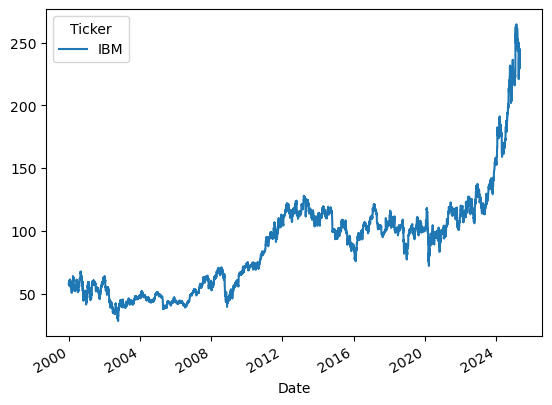

In [74]:
stockdt['Close'].plot()
plt.show()

# Technical Indicators

## 1. Momentum Features

### 1.1 RELATIVE STRENGTH INDEX (RSI)

It evaluates the conditions of overbought and oversold in the stock prices by measuring the extent of recent changes in prices. The RSI compares stock’s average gains and losses over a specific period of time, typically 14 trading days. RSI ranges between 0 and 100, and traditionally, RSI above 70 indicates that the stock is overbought, while RSI below 30 indicates that the stock is oversold.

$RSI = 100 - \dfrac{100}{1+RS}$ 

$RS = \frac{AverageGain}{AverageLoss}$


In [76]:
def RSI(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    
    avg_gain = gain.ewm(com=period, adjust=False).mean()
    avg_loss = loss.ewm(com=period, adjust=False).mean()
    
    rs = avg_gain/avg_loss
    rsi = 100 - (100 / (1+rs))
    
    return rsi

### 1.2 MOVING AVERAGE CONVERGENCE DIVERGENCE (MACD)

The moving average convergence divergence (MACD) is defined to be a trend-following momentum indicator that helps investors understand whether the bearish or bullish movement in prices is becoming stronger or weaker.

It is computed by subtracting the 26-day exponential moving average which is the longer moving average from the 12-day exponential moving average of a security’s prices which is defined to be the shorter one. The line obtained from this calculation called the MACD line and the 9-day exponential moving average of the MACD line called the signal line which can work as an incitement for buy and sell signals. However, MACD indicates a buy signal whenever it is above the signal line and a sell signal whenever it is below the signal line.

The formula for calculating MACD is as follows:

$MACD = EMA_{12}(C) - EMA_{26}(C)$

$SL = EMA_9(MACD)$

- MACD stands for moving average convergence divergence or MACD line
    - It measures momentum — how fast prices are changing.
    - If MACD > 0 → upward momentum; if MACD < 0 → downward momentum.
- SL stands for the signal line (usually 9-day EMA of MACD).
    - Acts as a trigger line.
    - When MACD crosses above it → bullish signal.
    - When MACD crosses below it → bearish signal.

- $EMA_n$= n-day exponential moving average
    - $EMA_t = \alpha.P_t + (1-\alpha).EMA_{t-1}$
    - EMA(12) is faster: it reacts quickly to recent price changes.
    - EMA(26) is slower: it smooths out short-term noise.
    - If EMA(12) > EMA(26), prices are moving up faster recently → positive momentum.
    - If EMA(12) < EMA(26), prices are moving down faster recently → negative momentum.

- C = closing price

In [93]:
def MACD(series):
    ema_12 = series.ewm(span=12, adjust=False).mean()
    ema_26 = series.ewm(span=26, adjust=False).mean()
    macd = ema_12 - ema_26
    signal = macd.ewm(span=9, adjust=False).mean()
    return macd, signal

### 1.3 PRICE RATE OF CHANGE (ROC)

The price rate of change (ROC) is another momentum oscillator that compares and cal- culates the percent change in price between the current price and the price n-periods ago. In other words, ROC measures the changes between the current price with respect to the earlier closing price in n days ago. It moves from positive to negative, and fluctuates above and below the zero-line. However, this oscillator can be used for determining the overbought and oversold conditions, divergences and also zero-line crossovers. 
- ROC tells you how much the price has increased or decreased in % over the past n periods.
- It's a simple way to measure momentum — how strong the trend is.

The formula for calculating ROC is as follows:

$ROC = \dfrac{C_t - C_{t-n}}{C_{t-n}} .100$

- ROC stands for price rate of change at time t
- $C_t$ = closing price at time t
- $C_{t-n}$ = closing price n periods ago

In [78]:
def ROC(series, period=14):
    return (series - series.shift(period)) * 100 / series.shift(period)

### 1.4 STOCHASTIC OSCILLATOR (%K)

The stochastic oscillator which is often denoted by the symbol (%K), is a momentum oscillator that was developed by George Lane. The stochastic oscillator identifies the location of the stock’s closing price relative to the high and low range of the stock’s price over a period of time, typically being 14 trading days. The stochastic oscillator varies from 0 to 100, a reading above 80 generally represents overbought while below 20 represents oversold. We use a 14-day time-frame %K. 

The formula for calculating the stochastic oscillator is given below:

$\% K = \dfrac{C_t - L_{14}}{H_{14} - L_{14}} \times 100$

- $C_t$ = the current closing price.
- $L_{14}$ = lowest low over the past 14 days 
- $H_{14}$ = highest high in the last 14 days

This formula yields a value between 0 and 100, indicating the closing price's position within the recent trading range. A higher %K value suggests the price is closing near its high, indicating upward momentum, while a lower %K value indicates the price is closing near its low, suggesting downward momentum.

In [ ]:
def STO_OS(close, low, high, period=14):
    low_14 = low.rolling(period).min()
    high_14 = high.rolling(period).max()
    return (close - low_14) * 100 / (high_14 - low_14)

### 1.5 COMMODITY CHANNEL INDEX (CCI)

The Commodity Channel Index (CCI) was developed by Donald Lambert, it is a useful oscillator that is used to estimate the direction and the strength of the stock price trend. This indicator is also used to determine when stock prices reach the condition of either overbought and oversold. The CCI is calculated by first determining the difference between the mean price of a stock and the average of the means, then comparing this difference to the average difference over a period of time, typically 20 days. The CCI is often scaled by an inverse factor of 0.015. 

The formula used to calculate the CCI is:

$CCI = \dfrac{TypicalPrice - SMA(TP)}{0.015 \times MeanDeviation}$

- Typical Price (TP) = (High + Low + Close) /3
- SMA(TP) = Simple Moving Average of TP over n periods (usually 20)
- Mean Deviation = Average of |TP - SMA| over n periods
- 0.015 is a constant that makes ~70-80% of CCI values fall between -100 and +100

In [89]:
def CCI(close, low, high, period=20):
    tp = (high + low + close) / 3
    sma_tp = tp.rolling(window=period).mean()
    mean_dev = tp.rolling(window=period).apply(lambda x: (abs(x - x.mean())).mean())
    
    cci = (tp - sma_tp) / (0.015 * mean_dev)
    return cci

### 1.6 DISPARITY INDEX (DIX)
The Disparity Index (DIX) is another useful indicator that is used commonly in technical analysis. This indicator was developed by Steve Nison and it is a momentum indicator that compares the stock’s current price with its moving average (MA) over a particular time period. DIX below 0 indicates that the stock’s current price is below the n-day MA, DIX above 0 indicates that the stock’s current price is above the n-day MA, whereas in the case the DIX equals 0 indicates that the stock’s current price is equal to the n-day MA. 

The formula for calculating the DIX is as follows:

$DIX = \dfrac{C_t - MA_{n}}{MA_{n}} \times 100$
- $C_t$ = current stock price.
- $MA_n$ = moving average over n days

Interpretation:
- Positive DIX (> 0): Price is above its moving average → up-momentum, possibly overbought if high enough.
- Negative DIX (< 0): Price is below its moving average → down-momentum, possibly oversold if low enough.
- “Zero line” crossovers:
    - Cross ↑ 0 → potential bullish signal
    - Cross ↓ 0 → potential bearish signal

Traders often watch for extreme readings—e.g., +10% or –10%—as overbought/oversold thresholds, though these will vary by asset and timeframe. 

In [94]:
def DIX(close, period=14, method='SMA'):
    if method.upper() == 'SMA':
        ma = close.rolling(window=period).mean()
    elif method.upper() == 'EMA':
        ma = close.ewm(span=period, adjust=False).mean()
    else:
        raise ValueError('Method must be SMA or EMA')
    
    dix = (close - ma) * 100 / ma
    return dix

## 2. Volatility features

### 2.1 AVERAGE TRUE RANGE (ATR)

ATR quantifies the average range of price fluctuations for an asset over a set number of periods, typically 14. It's particularly useful for identifying periods of high and low volatility, aiding traders in making informed decisions about entry and exit points.
- High ATR Values: Indicate increased volatility, suggesting larger price movements.
- Low ATR Values: Reflect decreased volatility, implying smaller price movements.
- Non-Directional Indicator: ATR measures the magnitude of price movements without indicating direction.

The formula for calculating ATR:

$TR_t = max(High_t - Low_t, \; |High_t - Close_{t-1}|, \; |Low_t - Close_{t-1})$

$ATR_t = \frac{1}{n}\sum_{i=0}^{n-1}TR_i$

OR

$ATR_t = \alpha.TR_t + (1-\alpha).ATR_{t-1} $

In [95]:
def ATR(close, low, high, period=14):
    prev_close = close.shift(1)
    tr1 = high - low
    tr2 = (high - prev_close).abs()
    tr3 = (low - prev_close).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    
    atr = tr.ewm(span=period, adjust=False).mean()

    return atr

## 3. Volume-based features

### 3.1 ON-BALANCE VOLUME (OBV)

On-Balance Volume (OBV) is a technical indicator used in trading to measure the flow of volume in relation to the price movement of an asset, typically a stock. It helps traders to identify potential buying and selling pressure based on volume changes, which can give insights into the strength or weakness of a price trend.

The core idea behind OBV is that volume precedes price movement, meaning that large volume changes often happen before significant price changes, and this can be a signal for future price movements.

$$
\text{OBV}_{\text{today}} = \text{OBV}_{\text{previous}} +
\begin{cases}
\text{Volume}_{\text{today}}, & \text{if } \text{Close}_{\text{today}} > \text{Close}_{\text{previous}} \\
-\text{Volume}_{\text{today}}, & \text{if } \text{Close}_{\text{today}} < \text{Close}_{\text{previous}} \\
0, & \text{if } \text{Close}_{\text{today}} = \text{Close}_{\text{previous}}
\end{cases}
$$


In [107]:
def OBV(close, volume):
    price_change_sign = np.sign(close.diff().fillna(0))
    signed_volume = volume * price_change_sign
    obv = signed_volume.cumsum()
    obv.name = 'OBV'
    return obv

### 3.2 CHAIKIN MONEY FLOW (CMF)
Chaikin Money Flow (CMF) is a technical analysis indicator that measures the buying and selling pressure over a given period. It uses both price and volume to show how much money is flowing into or out of a security.

CMF ranges between -1 and +1:
- Positive values (above 0) suggest accumulation (buying pressure).
- Negative values (below 0) suggest distribution (selling pressure).

To calculate CMF over a period $n$ (usually 20 days):

$$
\text{CMF}_n = \frac{\sum_{i=1}^{n} (\text{Money Flow Multiplier}_i \times \text{Volume}_i)}{\sum_{i=1}^{n} \text{Volume}_i}
$$

**Step-by-step:**

1.  **Money Flow Multiplier (MFM):**
    $$
    \text{MFM}_i = \frac{(\text{Close}_i - \text{Low}_i) - (\text{High}_i - \text{Close}_i)}{\text{High}_i - \text{Low}_i} = \frac{2 \cdot \text{Close}_i - \text{High}_i - \text{Low}_i}{\text{High}_i - \text{Low}_i}
    $$

2.  **Money Flow Volume (MFV):**
    $$
    \text{MFV}_i = \text{MFM}_i \times \text{Volume}_i
    $$

3.  **CMF over $n$ periods:**
    $$
    \text{CMF}_n = \frac{\sum_{i=1}^{n} \text{MFV}_i}{\sum_{i=1}^{n} \text{Volume}_i}
    $$

In [110]:
def CMF(close, low, high, volume, period=20):
    mfm = ((2 * close - high - low) / (high - low)).fillna(0)  
    mfv = mfm * volume 

    cmf = mfv.rolling(window=period).sum() / volume.rolling(window=period).sum()
    return cmf

# Feature Engineering

In [134]:
stockdt['RSI'] = RSI(stockdt['Close'])
stockdt['MACD'] = MACD(stockdt['Close'])[0]
stockdt['ROC'] = ROC(stockdt['Close'])
stockdt['%K'] = STO_OS(stockdt['Close'], stockdt['Low'], stockdt['High'])
stockdt['CCI'] = CCI(stockdt['Close'], stockdt['Low'], stockdt['High'])
stockdt['DIX'] = DIX(stockdt['Close'])

stockdt['ATR'] = ATR(stockdt['Close'], stockdt['Low'], stockdt['High'])

stockdt['OBV'] = OBV(stockdt['Close'], stockdt['Volume'])
stockdt['CMF'] = CMF(stockdt['Close'], stockdt['Low'], stockdt['High'], stockdt['Volume'])

stockdt.dropna(axis=0, inplace=True)

# Data Lebelling

In [135]:
stockdt['Target_30'] = np.sign(stockdt['Close'].shift(-30) - stockdt['Close'])

In [140]:
stockdt.dropna(axis=0, inplace=True)

In [141]:
stockdt

Price,Close,High,Low,Open,Volume,RSI,MACD,ROC,%K,CCI,DIX,ATR,OBV,CMF,Target_30
Ticker,IBM,IBM,IBM,IBM,IBM,,,,,,,,,,
Date,,,,,,,,,,,,,,,
2000-01-31,56.615864,56.899575,55.291885,56.174539,6488024,23.020302,-0.227801,-4.872830,17.355386,-143.083186,-4.573203,2.546554,-20068659.0,-0.103534,-1.0
2000-02-01,55.480988,57.214770,55.039663,56.678872,7640716,21.646864,-0.455256,-7.563076,5.599958,-144.497435,-5.972177,2.497027,-27709375.0,-0.190652,-1.0
2000-02-02,57.246300,58.412660,55.670135,56.489740,8062254,28.733196,-0.487450,-5.020947,27.999966,-88.716218,-2.623636,2.554980,-19647121.0,-0.167997,-1.0
2000-02-03,59.074688,59.263826,57.530043,58.002896,6499635,35.233391,-0.361265,-0.951376,51.200345,-14.431430,0.555790,2.483320,-13147486.0,-0.146480,-1.0
2000-02-04,58.318104,59.736651,57.908299,59.610558,5653944,33.863994,-0.318639,-3.343788,41.600065,-14.136929,-0.487954,2.395991,-18801430.0,-0.127123,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-12,249.630005,253.130005,245.529999,250.350006,3848800,48.870303,1.939441,-5.707481,20.921524,-105.010383,-1.915482,8.183153,449333714.0,0.148213,-1.0
2025-03-13,245.800003,249.270004,243.039993,248.800003,3862400,45.339021,1.181940,-5.996637,11.789866,-135.850138,-2.993468,7.970734,445471314.0,0.119107,-1.0


# Train-test split

In [166]:
X = stockdt.loc[:, 'RSI':'CMF']
y = stockdt.loc[:, 'Target_30']

X_train = X.loc['2000-01-01':'2025-01-01', :]
y_train = y.loc['2000-01-01':'2025-01-01']

X_test = X.loc['2025-01-01':, :]
y_test = y.loc['2025-01-01':]

# Tunning hyper-parameter using rolling cross-validation and train data

In [ ]:
grid_rf = {
'n_estimators': [100, 200, 300],  
'max_depth': [3, 5, 7, 9],  
'max_features': [3, 4, 5]
}

tscv = TimeSeriesSplit(n_splits=5)
gscv = GridSearchCV(estimator=RandomForestClassifier(random_state=36), param_grid=grid_rf, cv=tscv, scoring='accuracy')
gscv_fit = gscv.fit(X_train, y_train)
best_parameters = gscv_fit.best_params_
print("Hyperparameter: ", best_parameters)

model = RandomForestClassifier(**best_parameters, random_state=36)
model.fit(X_train, y_train)

Hyperparameter:  {'max_depth': 9, 'max_features': 4, 'n_estimators': 200}


RandomForestClassifier(max_depth=9, max_features=4, n_estimators=200,
                       random_state=36)

# Testing

In [168]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
confusion_mat = confusion_matrix(y_test, y_pred)

print("TARGET 30 DAYS FROM 2025-01-01 TO 2025-04-30")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(confusion_mat)

TARGET 30 DAYS FROM 2025-01-01 TO 2025-04-30
Accuracy: 0.6666666666666666
Precision: 0.7129934210526316
Recall: 0.7129934210526316
F1 Score: 0.6666666666666666
Confusion Matrix:
[[17 15]
 [ 2 17]]
